COVID-19 Detection

This project explores application of deep learning models to detect COVID-19 disease using chest X-ray images. The dataset 'COVID-19 CXR' is collected from Kaggle repository. Undersampling technique is used to balance data to prevent development of the bias model. Data pre-processing is performed to enhance the medical image quality. Dataset is divided into training, validation and test subset. Using fine-tuned transfer learning model, classified the medical images in test subset. Achieved optimal performance for the models.

In [1]:
#Mount the Google Drive
from google.colab import drive
drive.mount('/drive')

Mounted at /drive


In [2]:
! pip install kaggle

In [3]:
#Create Directory
! mkdir ~/.kaggle

In [4]:
#Copy the Kaggle JSON File
!cp "/drive/MyDrive/Colab Notebooks/kaggle.json" ~/.kaggle/
#Modify the permissions of JSON file
!chmod 600 ~/.kaggle/kaggle.json

In [7]:
!kaggle datasets download -d andyczhao/covidx-cxr2

100% 11.6G/11.6G [04:08<00:00, 94.6MB/s]
100% 11.6G/11.6G [04:08<00:00, 50.1MB/s]


In [8]:
#Export the data from zip file
import zipfile
with zipfile.ZipFile('/content/covidx-cxr2.zip', 'r') as zip_ref:
    zip_ref.extractall('/content')

In [10]:
#Import statement
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import os
import cv2
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications.resnet import ResNet50, ResNet152
from keras.applications.xception import Xception
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import regularizers
import keras
from keras.callbacks import EarlyStopping
import time

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score, roc_auc_score, confusion_matrix

In [12]:
#Read the dataset COVIDx CXR - 2
COVID_training_dataset = pd.read_csv('/content/train.txt', sep=" ", header=None)
COVID_test_dataset = pd.read_csv('/content/test.txt', sep=" ", header=None)

In [13]:
#As per the given description in Kaggle the columns are identified
COVID_training_dataset.columns=['Patient_id', 'Filename', 'Class', 'Data_source']
COVID_test_dataset.columns=['Patient_id', 'Filename', 'Class', 'Data_source']

In [14]:
#Calculate the number of records depending on class
print("Training dataset:\n", COVID_training_dataset.groupby('Class').size())
print("\n\nTest dataset:\n", COVID_test_dataset.groupby('Class').size())
#Total number of records matches with the given information on Kaggle

Training dataset:
 Class
negative    13793
positive     2158
dtype: int64


Test dataset:
 Class
negative    200
positive    200
dtype: int64


Text(0, 0.5, 'Count')

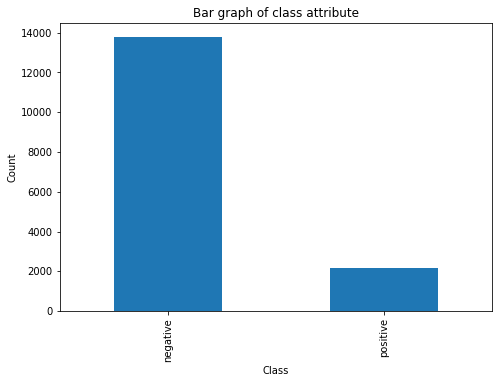

In [15]:
#Analysis the class attribute in the training dataset
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax = COVID_training_dataset['Class'].value_counts().plot(kind='bar')
ax.set_title("Bar graph of class attribute")
ax.set_xlabel("Class")
ax.set_ylabel("Count")

Text(0, 0.5, 'Count')

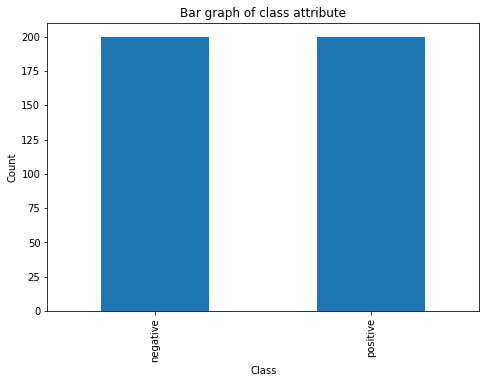

In [16]:
#Analysis the class attribute in the test dataset
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax = COVID_test_dataset['Class'].value_counts().plot(kind='bar')
ax.set_title("Bar graph of class attribute")
ax.set_xlabel("Class")
ax.set_ylabel("Count")

# Perform Undersampling

In [17]:
#Extract images as per the class name
negative_images  = COVID_training_dataset[COVID_training_dataset['Class'] == 'negative']
positive_images = COVID_training_dataset[COVID_training_dataset['Class'] == 'positive']

from sklearn.utils import resample

#The training dataset consist of majority class as negative, due which we need to decrease the number of images for no bias
#There are 2158 samples of class positive due to which we extracted 2158 negative images
df_extracted_dataset = resample(negative_images, replace = True, n_samples = 2158) 

#concatenate
training_dataset = pd.concat([positive_images, df_extracted_dataset])
training_dataset.head()

,Patient_id,Filename,Class,Data_source
404,2,auntminnie-a-2020_01_28_23_51_6665_2020_01_28_...,positive,cohen
405,2,auntminnie-b-2020_01_28_23_51_6665_2020_01_28_...,positive,cohen
406,2,auntminnie-c-2020_01_28_23_51_6665_2020_01_28_...,positive,cohen
407,2,auntminnie-d-2020_01_28_23_51_6665_2020_01_28_...,positive,cohen
408,4,nejmc2001573_f1a.jpeg,positive,cohen


In [18]:
#Dropped the unecessary columns
training_dataset=training_dataset.drop(['Patient_id', 'Data_source'], axis=1 )

#View the details of the resampled dataset
print(training_dataset['Class'].value_counts())
ls_all_images = training_dataset['Filename'].to_list()
print(len(ls_all_images))

positive    2158
negative    2158
Name: Class, dtype: int64
4316


In [20]:
#Delete the extra images
for value in COVID_training_dataset['Filename']:
    if not value in ls_all_images:
        path = "/content/train/" + value
        if os.path.exists(path):
            os.remove(path)
        else:
            print("The file does not exist")

In [21]:
#Extract the names of the selected images
selected_images = []
for value in COVID_training_dataset['Filename']:
  path = "/content/train/" + value;
  if os.path.exists(path):
    selected_images.append(value)
print(selected_images[0])

pneumocystis-jirovecii-pneumonia-3-2.jpg


In [22]:
#Display length of the selected images
print("Length of the selected images: ", len(selected_images))

Length of the selected images:  4177


In [27]:
#Convert the list to DataFrame
df_training = pd.DataFrame(selected_images, columns = ["Filename"])

#Merge the dataset
df_training = pd.merge(COVID_training_dataset, df_training, on=['Filename','Filename'])

df_training.head()

,Patient_id,Filename,Class,Data_source
0,101,pneumocystis-jirovecii-pneumonia-3-2.jpg,negative,cohen
1,102,pneumocystis-pneumonia-1.jpg,negative,cohen
2,214,16745_6_1.png,negative,cohen
3,276,000005-5-a.jpg,negative,cohen
4,278,000001-9-a.jpg,negative,cohen


In [24]:
#Display the value count
print("View the image count:\n",df_training['Class'].value_counts())

View the image count:
 positive    2158
negative    2019
Name: Class, dtype: int64


In [28]:
#Dropped the unecessary columns
df_training = df_training.drop(['Patient_id', 'Data_source'], axis=1)

#Save the DataFrame to the CSV file for future purpose
df_training.to_csv('training_data.csv', index = False)

#Read images from the COVID CXR dataset using OpenCV

In [29]:
#Read the CSV file for train dataset
df_training = pd.read_csv('/content/training_data.csv', sep=",")
df_training.head()

,Filename,Class
0,pneumocystis-jirovecii-pneumonia-3-2.jpg,negative
1,pneumocystis-pneumonia-1.jpg,negative
2,16745_6_1.png,negative
3,000005-5-a.jpg,negative
4,000001-9-a.jpg,negative


In [30]:
#Reshuffle image dataset
df_training = shuffle(df_training)

print(df_training.head())

#Save the dataframe
df_training.to_csv("/content/training_data.csv")

                                       Filename     Class
551                              COVID(195).png  positive
1154                             COVID(802).png  positive
765                              COVID(413).png  positive
1081                             COVID(729).png  positive
1399  MIDRC-RICORD-1C-440808-000005-8.301-0.png  positive


In [31]:
#Read the CSV file for train dataset
df_training = pd.read_csv('/content/training_data.csv', sep=",")

print(df_training.head())

#View the value count of class
print("\nValue count: \n", df_training['Class'].value_counts())

   Unnamed: 0                                   Filename     Class
0         551                             COVID(195).png  positive
1        1154                             COVID(802).png  positive
2         765                             COVID(413).png  positive
3        1081                             COVID(729).png  positive
4        1399  MIDRC-RICORD-1C-440808-000005-8.301-0.png  positive

Value count: 
 positive    2158
negative    2019
Name: Class, dtype: int64


In [34]:
#Read the CSV file for test dataset
df_testing = pd.read_csv('/content/test.txt', sep=" ", header = None)
df_testing.columns = ['Patient_id', 'Filename', 'Class', 'Data_source']

#Dropped the unecessary columns
df_testing=df_testing.drop(['Patient_id', 'Data_source'], axis = 1 )

#Reshuffle image dataset
df_testing = shuffle(df_testing)

print(df_testing.head())

#Save the dataframe
df_testing.to_csv("/content/SIT723_test.csv", index = False)

                                      Filename     Class
330   3186d210-966f-4733-ba72-98729be9551a.png  negative
380   b852bc3c-0de5-4448-aff8-f96b2cc13d51.png  negative
38   MIDRC-RICORD-1C-419639-003360-73998-0.png  positive
257   fd7bad9a-1bff-49ec-9c6c-c9aae9e65726.png  negative
120   MIDRC-RICORD-1C-SITE2-000097-16347-1.png  positive


In [35]:
#Read the CSV file for test dataset
df_testing = pd.read_csv('/content/SIT723_test.csv', sep=",")

print(df_testing.head())

#View the value count of class
print("\nValue count: \n", df_testing['Class'].value_counts())

                                    Filename     Class
0   3186d210-966f-4733-ba72-98729be9551a.png  negative
1   b852bc3c-0de5-4448-aff8-f96b2cc13d51.png  negative
2  MIDRC-RICORD-1C-419639-003360-73998-0.png  positive
3   fd7bad9a-1bff-49ec-9c6c-c9aae9e65726.png  negative
4   MIDRC-RICORD-1C-SITE2-000097-16347-1.png  positive

Value count: 
 negative    200
positive    200
Name: Class, dtype: int64


In [61]:
#Set directory
directory = "/content/train"
os.chdir(directory)

#Resize all the images in the dataset
for value in df_training['Filename']:
  img = cv2.imread(value)
  img = cv2.resize(img,(256,256))
  cv2.imwrite(value, img)

In [37]:
#Set directory
directory = "/content/test"
os.chdir(directory)

#Resize all the images in the dataset
for value in df_testing['Filename']:
  img = cv2.imread(value)
  img = cv2.resize(img,(256,256))
  cv2.imwrite(value, img)

In [64]:
#Read the images using OpenCV
image = []
for value in df_training['Filename']:
  path = "/content/train/" + value
  image.append(cv2.imread(path))

In [66]:
test_image = []
for value in df_testing['Filename']:
  path = "/content/test/" + value;
  test_image.append(cv2.imread(path))

In [67]:
#Display length of the images
print("Length of training dataset: ", len(image))
print("Length of test dataset: ", len(test_image))

Length of training dataset:  4177
Length of test dataset:  400


In [68]:
#Categorize the images with label 'Normal' and 'COVID'
label = []
for value in df_training['Filename']:
  state = str(df_training[df_training['Filename'] == value]['Class'])
  if "negative" in state:
    label.append(0)
  else:
    label.append(1)

test_label = []
for value in df_testing['Filename']:
  state = str(df_testing[df_testing['Filename'] == value]['Class'])
  if "negative" in state:
    test_label.append(0)
  else:
    test_label.append(1)

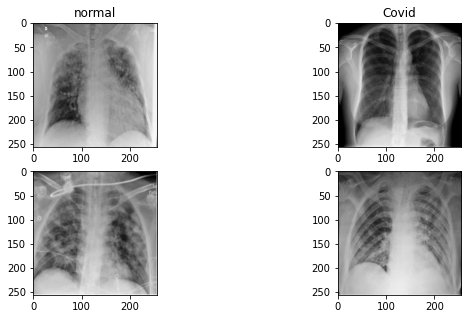

In [69]:
#Display the image data
plt.figure(figsize=(10,5));
plt.subplot(2,2,1)
im1= Image.fromarray(image[0])
plt.imshow(im1)
plt.title('normal')
plt.subplot(2,2,2)
im1= Image.fromarray(image[-1])
plt.imshow(im1)
plt.title('Covid')
plt.subplot(2,2,3)
im1= Image.fromarray(image[1])
plt.imshow(im1)
plt.subplot(2,2,4)
im1= Image.fromarray(image[-8])
plt.imshow(im1)

# Analysis of the images

In [70]:
#Define function to analyze the images
def EDA_ImageDataset(img):
  plt.imshow(img, cmap='gray')
  plt.colorbar()
  plt.title("Chest X-Ray Image")
  print(f"Dimensions: {img.shape[0]} pixels height, {img.shape[1]} pixels width")
  print(f"Maximum pixel: {img.max():.4f}")
  print(f"Minimum pixel: {img.min():.4f}")
  print(f"Mean value of the pixels: {img.mean():.4f}")
  print(f"Standard deviation: {img.std():.4f}")

Dimensions: 256 pixels height, 256 pixels width
Maximum pixel: 255.0000
Minimum pixel: 15.0000
Mean value of the pixels: 152.5609
Standard deviation: 43.3885


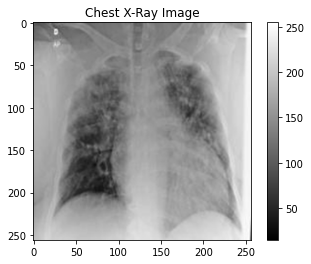

In [71]:
EDA_ImageDataset(image[0])

Dimensions: 256 pixels height, 256 pixels width
Maximum pixel: 220.0000
Minimum pixel: 0.0000
Mean value of the pixels: 167.4721
Standard deviation: 36.4960


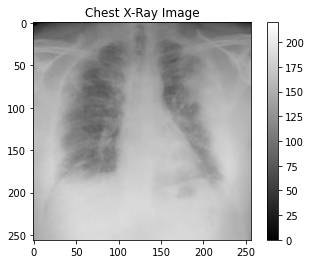

In [72]:
EDA_ImageDataset(image[2])

In [73]:
#Define function to plot a histogram
def Histogram_Image(img):
  plt.hist(img.ravel(),256,[0,256]) 
  plt.show()

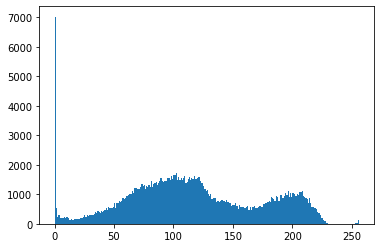

In [79]:
Histogram_Image(image[-9])
#The image is mostly dark, we see a huge cluster of pixels on position zero of the grayscale bar.

# Data pre-processing image dataset

In [80]:
#Display the image count
print("Length of the image dataset: ", len(image))
print("Length of the labels: ", len(label))

print("Length of the test dataset: ", len(test_image))
print("Length of the labels for test dataset: ", len(test_label))

Length of the image dataset:  4177
Length of the labels:  4177
Length of the test dataset:  400
Length of the labels for test dataset:  400


In [81]:
#Define image normalization function
def Image_Normalization(img):
  norm_img = np.zeros((800,800))
  for value in range(len(img)):
    img[value] = cv2.normalize(img[value],  norm_img, 0, 255, cv2.NORM_MINMAX)
  cv2.waitKey(0)
  cv2.destroyAllWindows()
  return img

In [82]:
image = Image_Normalization(image)
test_image = Image_Normalization(test_image)

In [83]:
#Define function for cropping image background
def Image_cropping(images):
  for value in range(len(images)):
    img = images[value]
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # threshold 
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]
    hh, ww = thresh.shape
    
    # make bottom 2 rows black where they are white the full width of the image
    thresh[hh-3:hh, 0:ww] = 0
    
    # get bounds of white pixels
    white = np.where(thresh==255)
    xmin, ymin, xmax, ymax = np.min(white[1]), np.min(white[0]), np.max(white[1]), np.max(white[0])

    # crop the image at the bounds adding back the two blackened rows at the bottom
    crop = img[ymin:ymax+3, xmin:xmax]
    images[value] = crop
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    return images

In [84]:
image = Image_cropping(image)
test_image = Image_cropping(test_image)

In [85]:
#Define function for text removal
def Text_Removal(images):
  for value in range(len(images)):
    img = images[value]
    mask = cv2.threshold(img, 240, 255, cv2.THRESH_BINARY)[1][:, :, 0].astype(np.uint8)
    img = img.astype(np.uint8)
    result = cv2.inpaint(img, mask, 10, cv2.INPAINT_NS).astype(np.float32)
    images[value] = (result * 255).astype(np.uint8)
    return images

In [86]:
image = Text_Removal(image)
test_image = Text_Removal(test_image)

In [87]:
#Define image resizing
def Image_Resizing(img):
    for value in range(len(img)):
      img[value] = cv2.resize(img[value],(224,224))
    return img

Dimensions: 224 pixels height, 224 pixels width
Maximum pixel: 252.0000
Minimum pixel: 16.0000
Mean value of the pixels: 110.5658
Standard deviation: 45.1517


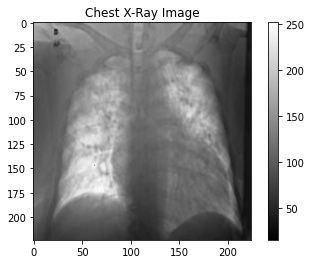

In [88]:
image = Image_Resizing(image)
EDA_ImageDataset(image[0])

Dimensions: 224 pixels height, 224 pixels width
Maximum pixel: 255.0000
Minimum pixel: 0.0000
Mean value of the pixels: 138.8311
Standard deviation: 55.5834


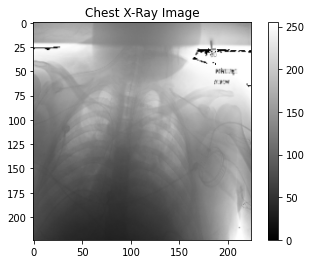

In [89]:
test_image = Image_Resizing(test_image)
EDA_ImageDataset(test_image[0])

In [90]:
#Form training and validation dataset
training_images, validate_images, training_labels, validate_labels = train_test_split(
    image, label, test_size = 0.2, random_state = 27, shuffle = False)

In [91]:
#Conversion of list to array
for value in range(len(validate_images)):
  validate_images[value] = img_to_array(validate_images[value])

In [92]:
#Conversion of list to array
for value in range(len(training_images)):
  training_images[value] = img_to_array(training_images[value])

In [93]:
#Conversion of list to array
for value in range(len(test_image)):
  test_image[value] = img_to_array(test_image[value])

In [94]:
#Convert images to array
training_images = np.array(training_images)
validate_images = np.array(validate_images)
test_image = np.array(test_image)

In [95]:
#Convert label to array
training_labels = np.array(training_labels)
validate_labels = np.array(validate_labels)
test_label = np.array(test_label)

In [96]:
#Build the input pipeline
datagen = ImageDataGenerator(
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    horizontal_flip = True,
    vertical_flip = False)
train_generator = datagen.flow(training_images, training_labels)
validation_generator = datagen.flow(validate_images, validate_labels)

# Deep learning model for image classification

In [97]:
#Calculate the performance metrics
def cal_performance_metric(test_label_1, prediction_label_1, prediction_prob):
  #Accuracy of the model
  accuracy = accuracy_score(test_label_1, prediction_label_1)
  print('Accuracy: %f' % accuracy)
  # precision tp / (tp + fp)
  precision = precision_score(test_label_1, prediction_label_1)
  print('Precision: %f' % precision)
  # recall: tp / (tp + fn)
  recall = recall_score(test_label_1, prediction_label_1)
  print('Recall: %f' % recall)
  # f1: 2 tp / (2 tp + fp + fn)
  f1 = f1_score(test_label_1, prediction_label_1)
  print('F1 score: %f' % f1)
  # kappa
  kappa = cohen_kappa_score(test_label_1, prediction_label_1)
  print('Cohens kappa: %f' % kappa)
  # ROC AUC
  auc = roc_auc_score(test_label_1, prediction_prob)
  print('ROC AUC: %f' % auc)
  # confusion matrix
  results = confusion_matrix(test_label_1, prediction_label_1)
  sns.set(rc={'figure.figsize':(9.7,6.27)})
  print("Confusion matrix: \n", sns.heatmap(results, annot=True, fmt='g'))

## VGG16 model

In [ ]:
#Build the model using Transfer learning
def build_model():
  #Build the convolution base
  conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(224,224,3))
  #View the details of the convolution base
  #print(conv_base.summary())
  print("Number of layers in the base model: ", len(conv_base.layers))
  # Freeze four convolution blocks
  for layer in conv_base.layers[:15]:
    layer.trainable = False
  
  # Make sure you have frozen the correct layers
  for i, layer in enumerate(conv_base.layers):
    print(i, layer.name, layer.trainable)

  model = models.Sequential()
  model.add(conv_base)
  model.add(layers.Flatten())
  model.add(layers.Dense(1, activation='sigmoid'))
  opt = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False)

  model.compile(optimizer = opt,
                loss = 'binary_crossentropy',
                metrics = ['accuracy'])
  model.build((None, 224, 224, 3))
  return model

In [ ]:
#Create the VGG16 fine tuned model
VGG_model = build_model()

#Display the model summary of VGG16 fine tuned model
VGG_model.summary()

58900480/58889256 [==============================] - 1s 0us/step
Number of layers in the base model:  19
0 input_2 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 25089     
Total params: 14,

In [ ]:
#Train the VGG16 fine tuned model
start = time.perf_counter()
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=20, verbose=1, mode='auto')
history_transferlearning = VGG_model.fit(train_generator,steps_per_epoch=100, epochs=100, 
                                         validation_data = validation_generator, batch_size = 24,callbacks=[early])
stop = time.perf_counter()

Epoch 1/100
100/100 [==============================] - 70s 590ms/step - loss: 0.6488 - accuracy: 0.7685 - val_loss: 0.3953 - val_accuracy: 0.8259
Epoch 2/100
100/100 [==============================] - 56s 562ms/step - loss: 0.3238 - accuracy: 0.8650 - val_loss: 0.3005 - val_accuracy: 0.8739
Epoch 3/100
100/100 [==============================] - 57s 565ms/step - loss: 0.2853 - accuracy: 0.8925 - val_loss: 0.3777 - val_accuracy: 0.8415
Epoch 4/100
100/100 [==============================] - 57s 564ms/step - loss: 0.2641 - accuracy: 0.8931 - val_loss: 0.4021 - val_accuracy: 0.8607
Epoch 5/100
100/100 [==============================] - 56s 564ms/step - loss: 0.2897 - accuracy: 0.8868 - val_loss: 0.2692 - val_accuracy: 0.8932
Epoch 6/100
100/100 [==============================] - 56s 563ms/step - loss: 0.2203 - accuracy: 0.9081 - val_loss: 0.2320 - val_accuracy: 0.9268
Epoch 7/100
100/100 [==============================] - 56s 562ms/step - loss: 0.2065 - accuracy: 0.9161 - val_loss: 0.2646 -

Prediction probability:  [[7.3178196e-03]
 [1.0000000e+00]
 [1.0000000e+00]
 [7.8856182e-01]
 [2.0973332e-09]]
Prediction label:  [[0]
 [1]
 [1]
 [1]
 [0]]
Accuracy: 0.950000
Precision: 0.994505
Recall: 0.905000
F1 score: 0.947644
Cohens kappa: 0.900000
ROC AUC: 0.994225
Confusion matrix: 
 AxesSubplot(0.125,0.125;0.62x0.755)


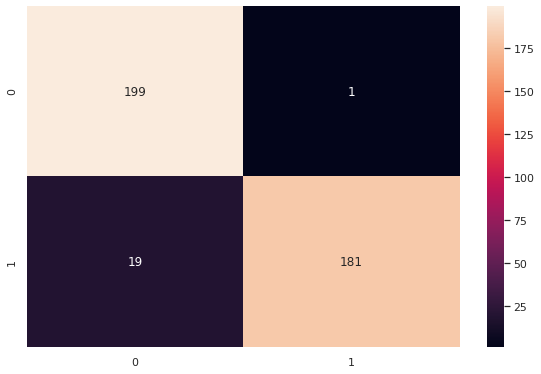

In [ ]:
#Predict the label of the test dataset
prediction_prob = VGG_model.predict(test_image)
print("Prediction probability: ", prediction_prob[:5])
prediction_label = np.where(prediction_prob > 0.5, 1,0)
print("Prediction label: ", prediction_label[:5])

#Evaluate the model performance
cal_performance_metric(test_label,prediction_label, prediction_prob)

In [ ]:
print(f"Model execution time {stop - start:0.4f} seconds")

Model execution time 3496.9310 seconds


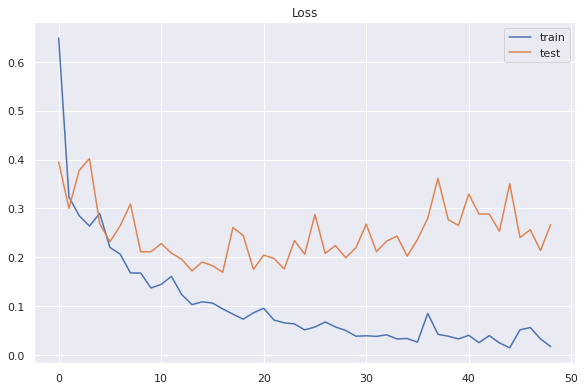

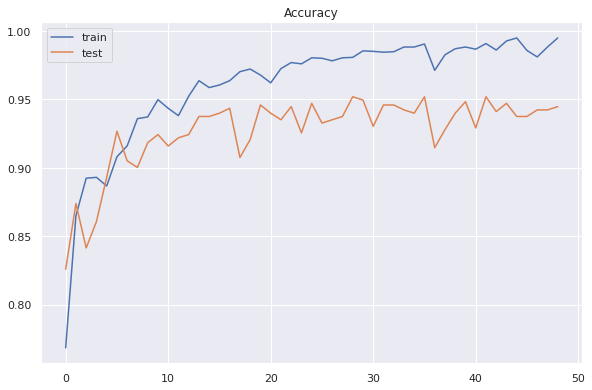

In [ ]:
#Plot loss during training model
plt.title('Loss')
plt.plot(history_transferlearning.history['loss'], label='train')
plt.plot(history_transferlearning.history['val_loss'], label='test')
plt.legend()
plt.show()

#Plot accuracy during training
plt.title('Accuracy')
plt.plot(history_transferlearning.history['accuracy'], label='train')
plt.plot(history_transferlearning.history['val_accuracy'], label='test')
plt.legend()
plt.show()

## VGG19 model

In [ ]:
#Build the model using Transfer learning
def build_model_VGG19():
  #Build the convolution base
  conv_base = VGG19(weights='imagenet',
                  include_top=False,
                  input_shape=(224,224,3))
  #View the details of the convolution base
  #print(conv_base.summary())

  # Freeze four convolution blocks
  for layer in conv_base.layers[:15]:
    layer.trainable = False
  
  # Make sure you have frozen the correct layers
  for i, layer in enumerate(conv_base.layers):
    print(i, layer.name, layer.trainable)

  model = models.Sequential()
  model.add(conv_base)
  model.add(layers.Flatten())
  model.add(layers.Dense(1, activation='sigmoid'))
  opt = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False)

  model.compile(optimizer = opt,
                loss = 'binary_crossentropy',
                metrics = ['accuracy'])
  model.build((None, 224, 224, 3))
  return model

In [ ]:
#Create the VGG19 fine tuned model
VGG19_model = build_model_VGG19()

#Display VGG19 model summary
VGG19_model.summary()

80150528/80134624 [==============================] - 1s 0us/step
0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_conv4 False
11 block3_pool False
12 block4_conv1 False
13 block4_conv2 False
14 block4_conv3 False
15 block4_conv4 True
16 block4_pool True
17 block5_conv1 True
18 block5_conv2 True
19 block5_conv3 True
20 block5_conv4 True
21 block5_pool True
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 1)                 25089  

In [ ]:
#Train the VGG19 fine tuned model
start = time.perf_counter() 
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=20, verbose=1, mode='auto')
history_transferlearning = VGG19_model.fit(train_generator,steps_per_epoch=100, epochs=100, 
                                         validation_data = validation_generator, batch_size = 24,callbacks=[early])
stop = time.perf_counter()

Epoch 1/100
100/100 [==============================] - 101s 630ms/step - loss: 0.5752 - accuracy: 0.7701 - val_loss: 0.3439 - val_accuracy: 0.8535
Epoch 2/100
100/100 [==============================] - 61s 605ms/step - loss: 0.3610 - accuracy: 0.8477 - val_loss: 0.3032 - val_accuracy: 0.8776
Epoch 3/100
100/100 [==============================] - 60s 602ms/step - loss: 0.2942 - accuracy: 0.8751 - val_loss: 0.2725 - val_accuracy: 0.9016
Epoch 4/100
100/100 [==============================] - 60s 602ms/step - loss: 0.2456 - accuracy: 0.9060 - val_loss: 0.2509 - val_accuracy: 0.9052
Epoch 5/100
100/100 [==============================] - 62s 622ms/step - loss: 0.2314 - accuracy: 0.9085 - val_loss: 0.3098 - val_accuracy: 0.8643
Epoch 6/100
100/100 [==============================] - 60s 603ms/step - loss: 0.2011 - accuracy: 0.9190 - val_loss: 0.2386 - val_accuracy: 0.9112
Epoch 7/100
100/100 [==============================] - 60s 600ms/step - loss: 0.1804 - accuracy: 0.9275 - val_loss: 0.1947 

Prediction probability:  [[8.1172541e-02]
 [1.0000000e+00]
 [1.0000000e+00]
 [9.9692208e-01]
 [5.7574527e-09]]
Prediction label:  [[0]
 [1]
 [1]
 [1]
 [0]]
Accuracy: 0.982500
Precision: 0.989848
Recall: 0.975000
F1 score: 0.982368
Cohens kappa: 0.965000
ROC AUC: 0.998200
Confusion matrix: 
 AxesSubplot(0.125,0.125;0.62x0.755)


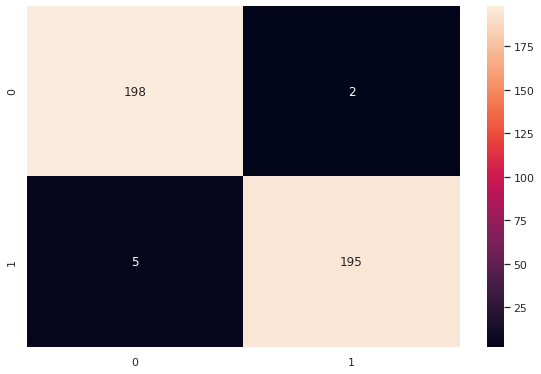

In [ ]:
#Predict the label for VGG19 fined tuned model
prediction_prob = VGG19_model.predict(test_image)
print("Prediction probability: ", prediction_prob[:5])
prediction_label = np.where(prediction_prob > 0.5, 1,0)
print("Prediction label: ", prediction_label[:5])

cal_performance_metric(test_label,prediction_label, prediction_prob)

In [ ]:
print(f"Model execution time {stop - start:0.4f} seconds")

Model execution time 3355.2120 seconds


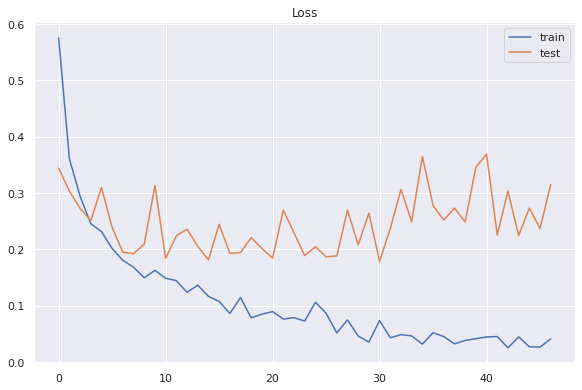

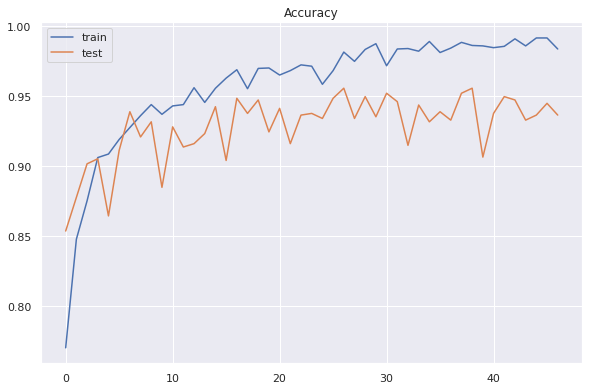

In [ ]:
#Plot loss during training model
plt.title('Loss')
plt.plot(history_transferlearning.history['loss'], label='train')
plt.plot(history_transferlearning.history['val_loss'], label='test')
plt.legend()
plt.show()

#Plot accuracy during training
plt.title('Accuracy')
plt.plot(history_transferlearning.history['accuracy'], label='train')
plt.plot(history_transferlearning.history['val_accuracy'], label='test')
plt.legend()
plt.show()

## ResNet-50 model

In [ ]:
#Build the model using Transfer learning
def build_model_ResNet50():
  #Build the convolution base
  conv_base = ResNet50(weights='imagenet',
                  include_top=False,
                  input_shape=(224,224,3))
  #View the details of the convolution base
  #print(conv_base.summary())

  # Freeze four convolution blocks
  for layer in conv_base.layers[:40]:
    layer.trainable = False
  
  # Make sure you have frozen the correct layers
  for i, layer in enumerate(conv_base.layers):
    print(i, layer.name, layer.trainable)

  model = models.Sequential()
  model.add(conv_base)
  model.add(layers.Flatten())
  model.add(layers.Dense(1, activation='sigmoid'))
  opt = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False)

  model.compile(optimizer = opt,
                loss = 'binary_crossentropy',
                metrics = ['accuracy'])
  model.build((None, 224, 224, 3))
  return model

In [ ]:
#Create the ResNet50 model
ResNet_model = build_model_ResNet50()

#Display the ResNet50 model summary
ResNet_model.summary()

94781440/94765736 [==============================] - 1s 0us/step
0 input_2 False
1 conv1_pad False
2 conv1_conv False
3 conv1_bn False
4 conv1_relu False
5 pool1_pad False
6 pool1_pool False
7 conv2_block1_1_conv False
8 conv2_block1_1_bn False
9 conv2_block1_1_relu False
10 conv2_block1_2_conv False
11 conv2_block1_2_bn False
12 conv2_block1_2_relu False
13 conv2_block1_0_conv False
14 conv2_block1_3_conv False
15 conv2_block1_0_bn False
16 conv2_block1_3_bn False
17 conv2_block1_add False
18 conv2_block1_out False
19 conv2_block2_1_conv False
20 conv2_block2_1_bn False
21 conv2_block2_1_relu False
22 conv2_block2_2_conv False
23 conv2_block2_2_bn False
24 conv2_block2_2_relu False
25 conv2_block2_3_conv False
26 conv2_block2_3_bn False
27 conv2_block2_add False
28 conv2_block2_out False
29 conv2_block3_1_conv False
30 conv2_block3_1_bn False
31 conv2_block3_1_relu False
32 conv2_block3_2_conv False
33 conv2_block3_2_bn False
34 conv2_block3_2_relu False
35 conv2_block3_3_conv False
3

In [ ]:
#Train the ResNet 50 model
start = time.perf_counter()
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=20, verbose=1, mode='auto')
history = ResNet_model.fit(train_generator,steps_per_epoch=100, epochs=100, 
                                         validation_data = validation_generator, batch_size = 24,callbacks=[early])
stop = time.perf_counter()

Epoch 1/100
100/100 [==============================] - 69s 688ms/step - loss: 0.1169 - accuracy: 0.9694 - val_loss: 1.0074 - val_accuracy: 0.8752
Epoch 2/100
100/100 [==============================] - 69s 691ms/step - loss: 0.0955 - accuracy: 0.9791 - val_loss: 0.1710 - val_accuracy: 0.9556
Epoch 3/100
100/100 [==============================] - 69s 690ms/step - loss: 0.0327 - accuracy: 0.9880 - val_loss: 0.2156 - val_accuracy: 0.9532
Epoch 4/100
100/100 [==============================] - 69s 686ms/step - loss: 0.0284 - accuracy: 0.9896 - val_loss: 0.2078 - val_accuracy: 0.9628
Epoch 5/100
100/100 [==============================] - 69s 689ms/step - loss: 0.0333 - accuracy: 0.9880 - val_loss: 0.2019 - val_accuracy: 0.9448
Epoch 6/100
100/100 [==============================] - 69s 690ms/step - loss: 0.0279 - accuracy: 0.9905 - val_loss: 0.2073 - val_accuracy: 0.9580
Epoch 7/100
100/100 [==============================] - 69s 688ms/step - loss: 0.0404 - accuracy: 0.9842 - val_loss: 0.2412 -

Prediction probability:  [[7.6985982e-04]
 [1.0000000e+00]
 [1.0000000e+00]
 [9.9998653e-01]
 [3.2499728e-10]]
Prediction label:  [[0]
 [1]
 [1]
 [1]
 [0]]
Accuracy: 0.990000
Precision: 0.990000
Recall: 0.990000
F1 score: 0.990000
Cohens kappa: 0.980000
ROC AUC: 0.990000
Confusion matrix: 
 AxesSubplot(0.125,0.125;0.62x0.755)


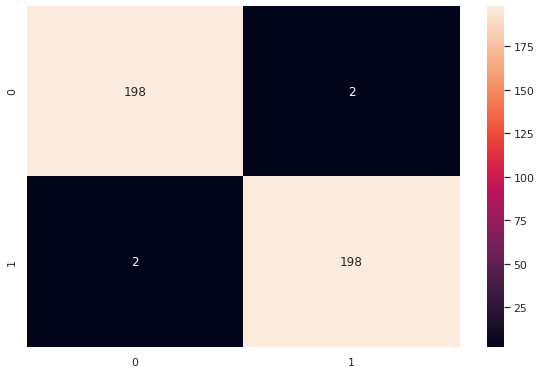

In [ ]:
#Predict the test dataset label
prediction_prob = ResNet_model.predict(test_image)
print("Prediction probability: ", prediction_prob[:5])
prediction_label = np.where(prediction_prob > 0.5, 1,0)
print("Prediction label: ", prediction_label[:5])

#Evaluate the ResNet50 model performance
cal_performance_metric(test_label,prediction_label)

In [ ]:
print(f"Model execution time {stop - start:0.4f} seconds")

Model execution time 3365.6683 seconds


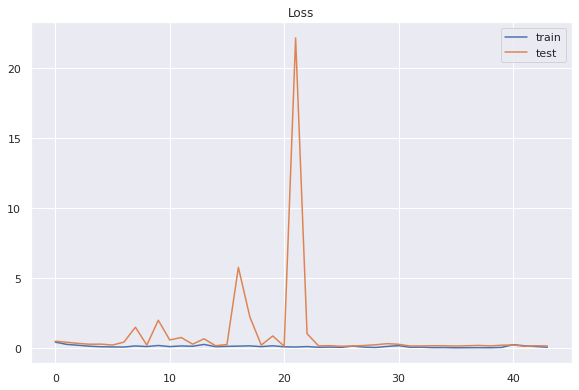

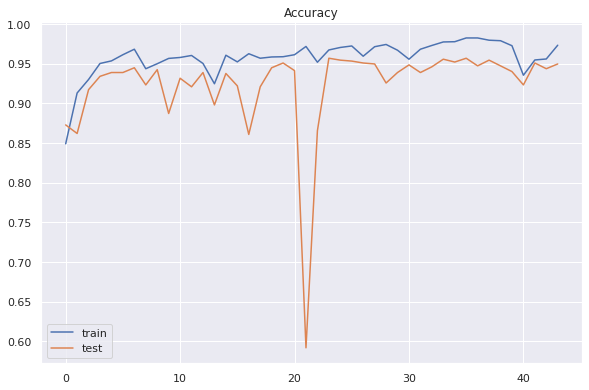

In [ ]:
#Plot loss during training model
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

#Plot accuracy during training
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

## Xception model

In [ ]:
#Build the model using Transfer learning
def build_model_Xception():
  #Build the convolution base
  conv_base = Xception(weights='imagenet',
                  include_top=False,
                  input_shape=(224,224,3))
  #View the details of the convolution base
  #print(conv_base.summary())

  # Un-Freeze all the layers of convolution blocks
  conv_base.trainable = True
  #Display layers are in the base model
  print("Number of layers in the base model: ", len(conv_base.layers))

  # Fine-tune from this layer onwards
  fine_tune_at = 100

  # Freeze all the layers before the `fine_tune_at` layer
  for layer in conv_base.layers[:fine_tune_at]:
    layer.trainable =  False
  # Display all the layers to verfify correct layers are frozen
  for i, layer in enumerate(conv_base.layers):
    print(i, layer.name, layer.trainable)

  model = models.Sequential()
  model.add(conv_base)
  model.add(layers.Flatten())
  model.add(layers.Dense(1, activation='sigmoid'))
  opt = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False)

  model.compile(optimizer = opt,
                loss = 'binary_crossentropy',
                metrics = ['accuracy'])
  model.build((None, 224, 224, 3))
  return model

In [ ]:
#Create the Xception model
Xception_model = build_model_Xception()

#Display the Xception model summary
Xception_model.summary()

83697664/83683744 [==============================] - 1s 0us/step
Number of layers in the base model:  132
0 input_2 False
1 block1_conv1 False
2 block1_conv1_bn False
3 block1_conv1_act False
4 block1_conv2 False
5 block1_conv2_bn False
6 block1_conv2_act False
7 block2_sepconv1 False
8 block2_sepconv1_bn False
9 block2_sepconv2_act False
10 block2_sepconv2 False
11 block2_sepconv2_bn False
12 conv2d False
13 block2_pool False
14 batch_normalization False
15 add False
16 block3_sepconv1_act False
17 block3_sepconv1 False
18 block3_sepconv1_bn False
19 block3_sepconv2_act False
20 block3_sepconv2 False
21 block3_sepconv2_bn False
22 conv2d_1 False
23 block3_pool False
24 batch_normalization_1 False
25 add_1 False
26 block4_sepconv1_act False
27 block4_sepconv1 False
28 block4_sepconv1_bn False
29 block4_sepconv2_act False
30 block4_sepconv2 False
31 block4_sepconv2_bn False
32 conv2d_2 False
33 block4_pool False
34 batch_normalization_2 False
35 add_2 False
36 block5_sepconv1_act False


In [ ]:
#Train the Xception model
start = time.perf_counter()
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=20, verbose=1, mode='auto')
history = Xception_model.fit(train_generator,steps_per_epoch=100, epochs=100, 
                                         validation_data = validation_generator, batch_size = 24,callbacks=[early])
stop = time.perf_counter()

Epoch 1/100
100/100 [==============================] - 72s 659ms/step - loss: 0.5832 - accuracy: 0.6916 - val_loss: 0.6853 - val_accuracy: 0.5402
Epoch 2/100
100/100 [==============================] - 64s 636ms/step - loss: 0.4644 - accuracy: 0.7821 - val_loss: 0.7990 - val_accuracy: 0.5822
Epoch 3/100
100/100 [==============================] - 64s 636ms/step - loss: 0.4448 - accuracy: 0.7922 - val_loss: 0.6852 - val_accuracy: 0.6375
Epoch 4/100
100/100 [==============================] - 64s 635ms/step - loss: 0.4008 - accuracy: 0.8180 - val_loss: 0.4623 - val_accuracy: 0.7707
Epoch 5/100
100/100 [==============================] - 64s 637ms/step - loss: 0.3986 - accuracy: 0.8228 - val_loss: 0.4109 - val_accuracy: 0.8175
Epoch 6/100
100/100 [==============================] - 64s 635ms/step - loss: 0.3841 - accuracy: 0.8275 - val_loss: 0.9294 - val_accuracy: 0.6098
Epoch 7/100
100/100 [==============================] - 72s 722ms/step - loss: 0.3602 - accuracy: 0.8404 - val_loss: 0.3768 -

Prediction probability:  [[0.9562384 ]
 [0.99999976]
 [0.99998367]
 [0.9398661 ]
 [0.04899184]]
Prediction label:  [[1]
 [1]
 [1]
 [1]
 [0]]
Accuracy: 0.807500
Precision: 0.722022
Recall: 1.000000
F1 score: 0.838574
Cohens kappa: 0.615000
ROC AUC: 0.973525
Confusion matrix: 
 AxesSubplot(0.125,0.125;0.62x0.755)


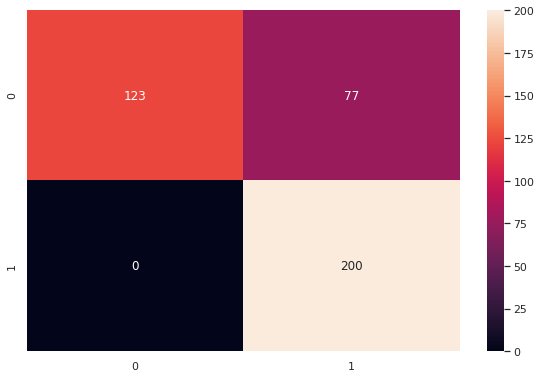

In [ ]:
#Predict the test dataset label
prediction_prob = Xception_model.predict(test_image)
print("Prediction probability: ", prediction_prob[:5])
prediction_label = np.where(prediction_prob > 0.5, 1,0)
print("Prediction label: ", prediction_label[:5])

#Evaluate the Xception model performance
cal_performance_metric(test_label,prediction_label, prediction_prob)

In [ ]:
print(f"Model execution time {stop - start:0.4f} seconds")

Model execution time 3054.0422 seconds


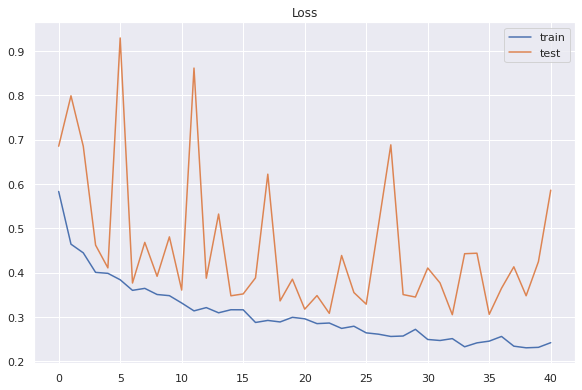

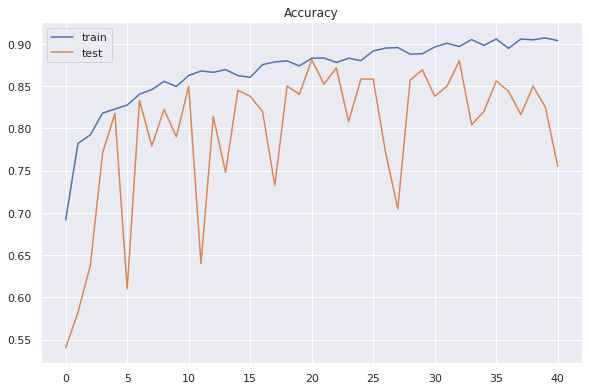

In [ ]:
#Plot loss during training model
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

#Plot accuracy during training
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

## EfficientNet-B1 model

In [ ]:
#Build the model using Transfer learning
def build_model_EfficientNet():
  #Build the convolution base
  conv_base = EfficientNetB1(weights='imagenet',
                  include_top=False,
                  input_shape=(224,224,3))
  #View the details of the convolution base
  #print(conv_base.summary())
  
  #Freeze 'first 234 layers' and unfreeze the remaining layers
  for layer in conv_base.layers[:234]:
   layer.trainable = False
  for layer in conv_base.layers[234:]:
   layer.trainable = True
  
  # Display all the layers to verfify correct layers are frozen
  for i, layer in enumerate(conv_base.layers):
    print(i, layer.name, layer.trainable)

  model = models.Sequential()
  model.add(conv_base)
  model.add(layers.Flatten())
  model.add(layers.Dense(1, activation='sigmoid'))
  opt = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False)

  model.compile(optimizer = opt,
                loss = 'binary_crossentropy',
                metrics = ['accuracy'])
  model.build((None, 224, 224, 3))
  return model

In [ ]:
#Create the EfficientNet-B1 model
Efficient_model = build_model_EfficientNet()

#Display the EfficientNet-B1 model summary
Efficient_model.summary()

27033600/27018416 [==============================] - 0s 0us/step
0 input_1 False
1 rescaling False
2 normalization False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block1b_dwconv False
18 block1b_bn False
19 block1b_activation False
20 block1b_se_squeeze False
21 block1b_se_reshape False
22 block1b_se_reduce False
23 block1b_se_expand False
24 block1b_se_excite False
25 block1b_project_conv False
26 block1b_project_bn False
27 block1b_drop False
28 block1b_add False
29 block2a_expand_conv False
30 block2a_expand_bn False
31 block2a_expand_activation False
32 block2a_dwconv_pad False
33 block2a_dwconv False
34 block2a_bn False
35 block2a_activation False
36 block2a_se_squeeze False
37 blo

In [ ]:
#Train the EfficientNet B1 model
start = time.perf_counter()
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=20, verbose=1, mode='auto')
history = Efficient_model.fit(train_generator,steps_per_epoch=100, epochs=100, 
                                         validation_data = validation_generator, batch_size = 24,callbacks=[early])
stop = time.perf_counter()

Epoch 1/100
100/100 [==============================] - 98s 591ms/step - loss: 0.4026 - accuracy: 0.8247 - val_loss: 0.4486 - val_accuracy: 0.8151
Epoch 2/100
100/100 [==============================] - 56s 555ms/step - loss: 0.2301 - accuracy: 0.9117 - val_loss: 0.3108 - val_accuracy: 0.8860
Epoch 3/100
100/100 [==============================] - 56s 559ms/step - loss: 0.2012 - accuracy: 0.9212 - val_loss: 0.2150 - val_accuracy: 0.9232
Epoch 4/100
100/100 [==============================] - 56s 559ms/step - loss: 0.1644 - accuracy: 0.9395 - val_loss: 0.1852 - val_accuracy: 0.9304
Epoch 5/100
100/100 [==============================] - 56s 555ms/step - loss: 0.1384 - accuracy: 0.9445 - val_loss: 0.1733 - val_accuracy: 0.9400
Epoch 6/100
100/100 [==============================] - 56s 555ms/step - loss: 0.1289 - accuracy: 0.9543 - val_loss: 0.1657 - val_accuracy: 0.9376
Epoch 7/100
100/100 [==============================] - 56s 558ms/step - loss: 0.1105 - accuracy: 0.9622 - val_loss: 0.2047 -

Prediction probability:  [[4.4072786e-01]
 [1.0000000e+00]
 [9.9999976e-01]
 [9.9996758e-01]
 [1.1026449e-07]]
Prediction label:  [[0]
 [1]
 [1]
 [1]
 [0]]
Accuracy: 0.977500
Precision: 0.965854
Recall: 0.990000
F1 score: 0.977778
Cohens kappa: 0.955000
ROC AUC: 0.993975
Confusion matrix: 
 AxesSubplot(0.125,0.125;0.62x0.755)


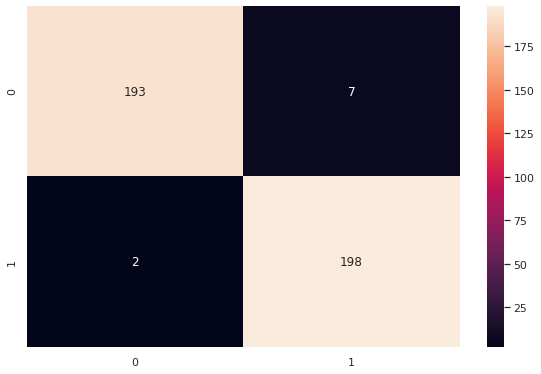

In [ ]:
#Predict the test dataset label
prediction_prob = Efficient_model.predict(test_image)
print("Prediction probability: ", prediction_prob[:5])
prediction_label = np.where(prediction_prob > 0.5, 1,0)
print("Prediction label: ", prediction_label[:5])

#Evaluate the EfficientNet-B1 model performance
cal_performance_metric(test_label,prediction_label, prediction_prob)

Model execution time 2839.8002 seconds


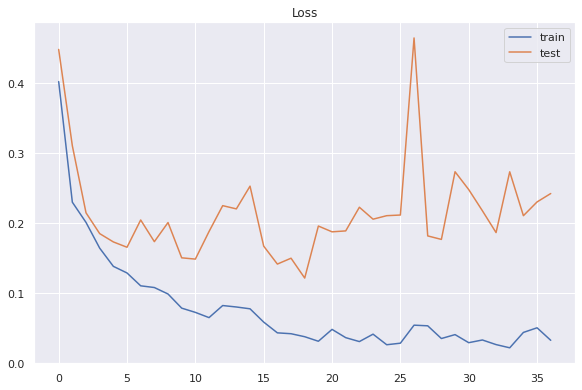

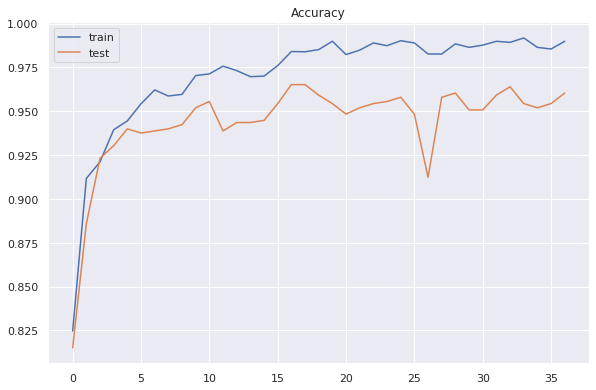

In [ ]:
print(f"Model execution time {stop - start:0.4f} seconds")

#Plot loss during training model
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

#Plot accuracy during training
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

#Performance Summary

Following is the performance metric of all the implemented models:

Model | Accuracy | Precision | Recall | F1 Score | Cohens kappa | ROC AUC | Execution Time | Epoch using Early Stopping
---|---|:---|:---:|---:|---:|---:|---:|---:|
VGG16 model | 95.00 | 99.45 | 90.50 | 94.76 | 90 | 99.42 | 3496.9310 seconds | 49
VGG19 model | 98.25	| 98.98	| 97.5	| 98.23	| 96.5	| 99.82 | 3355.2120 seconds | 47
ResNet50 model	| 99	| 99	| 99	| 99	| 98	| 99 | 3365.6683 seconds | 36
Xception model	| 80.75	| 72.22	| 100	| 83.85	| 61.5	| 97.35 | 3054.0422 seconds | 41
EfficientNet-B1	| 97.75	| 96.58	| 99	| 97.77	| 95.5	| 99.39 | 2839.8002 seconds | 37


Model | True Positive | False Positive | False Negative | True Negative
---:|---:|---:|:---|:---:|
VGG16 model | 199 | 1 | 19 | 181
VGG19 model | 198 | 2 | 5 | 195
ResNet50 model	| 198 | 2 | 2 | 198
Xception model	| 123 | 77 | 0 | 200
EfficientNet-B1	| 193 | 7 | 2 | 198

After performance comparison, the result of the experiments depicts ResNet50 model achieves the highest accuracy of 99% using the testing dataset. The ResNet50 model achieves the highest number of True positive and True negative value in the confusion matrix for the testing dataset. We have achieved 99% precision, recall and F1-score for the ResNet50 model. Using the early stop mechanism, model training process is stopped once the network performance does not improve for the validation dataset.

Although the initial accuracy values are less, a gradual increase is observed for both the subsets of data. It can be considered during the early stage of training model is not certain about the prediction of labels. However, as the model is trained further, increase in validation accuracy is observed. After comparison of the curve, we conclude the loss decreases while the accuracy increases for training and validation dataset. The model is learning some useful patterns in the data which are necessary for generalization as more images are classified correctly. By analyzing the loss curve, it can be stated that a decrease in loss value is observed which indicates the model is predicting correctly and sure about the predictions.